In [1]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

# authenticate
credential = DefaultAzureCredential()

SUBSCRIPTION = "a3c15ce6-40ee-4f4c-8e41-c54ae5dcd096"
RESOURCE_GROUP = "vutukurusrilekha-rg"
WS_NAME = "fathom-net-kaggle-comp"
# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id=SUBSCRIPTION,
    resource_group_name=RESOURCE_GROUP,
    workspace_name=WS_NAME,
)

FileNotFoundError: [Errno 2] No such file or directory: 'null/Users/vutukurusrilekha'

In [4]:
# Verify that the handle works correctly.
# If you ge an error here, modify your SUBSCRIPTION, RESOURCE_GROUP, and WS_NAME in the previous cell.
ws = ml_client.workspaces.get(WS_NAME)
print(ws.location, ":", ws.resource_group)

westus : vutukurusrilekha-rg


In [5]:
print("starting training...")

starting training...


In [1]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import open_clip

/home/azureuser/cloudfiles/code/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load BioCLIP model and preprocessors
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:imageomics/bioclip')
tokenizer = open_clip.get_tokenizer('hf-hub:imageomics/bioclip')

In [5]:
# Load annotations CSV
annotations = pd.read_csv("dataset/train/annotations.csv")

# Create a mapping from concept_name (species names) to numerical index
label_mapping = {name: idx for idx, name in enumerate(annotations["label"].unique())}

# Function to convert labels into numerical values
def encode_label(label):
    return torch.tensor(label_mapping[label], dtype=torch.long)

In [10]:
class MarineDataset(Dataset):
    def __init__(self, base_path, image_folder, roi_folder, annotations_csv, transform=None):
        self.base_path = base_path
        self.image_folder = image_folder
        self.roi_folder = roi_folder
        self.annotations = pd.read_csv(os.path.join(base_path, annotations_csv))
        self.transform = transform
        self.label_mapping = {name: idx for idx, name in enumerate(self.annotations["label"].unique())}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        row = self.annotations.iloc[idx]
        roi_path = os.path.join(self.base_path, self.roi_folder, row['path'])  # ROI image
        label = encode_label(row['label'])  # Encode label

        image = Image.open(roi_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = MarineDataset("dataset/train/", "images/", "roi/", "annotations.csv", transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)


In [11]:
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader

def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    num_samples = 0
    
    for images, _ in loader:
        images = images.view(images.size(0), 3, -1)  # Flatten each image
        mean += images.mean(dim=2).sum(dim=0)
        std += images.std(dim=2).sum(dim=0)
        num_samples += images.size(0)

    mean /= num_samples
    std /= num_samples

    return mean.numpy(), std.numpy()

# Run calculation on your dataset
mean, std = compute_mean_std(train_dataset)
print("Mean:", mean)
print("Std Dev:", std)

Mean: [-0.5574347  -0.1175186  -0.12466498]
Std Dev: [0.3460381  0.3590055  0.30271783]


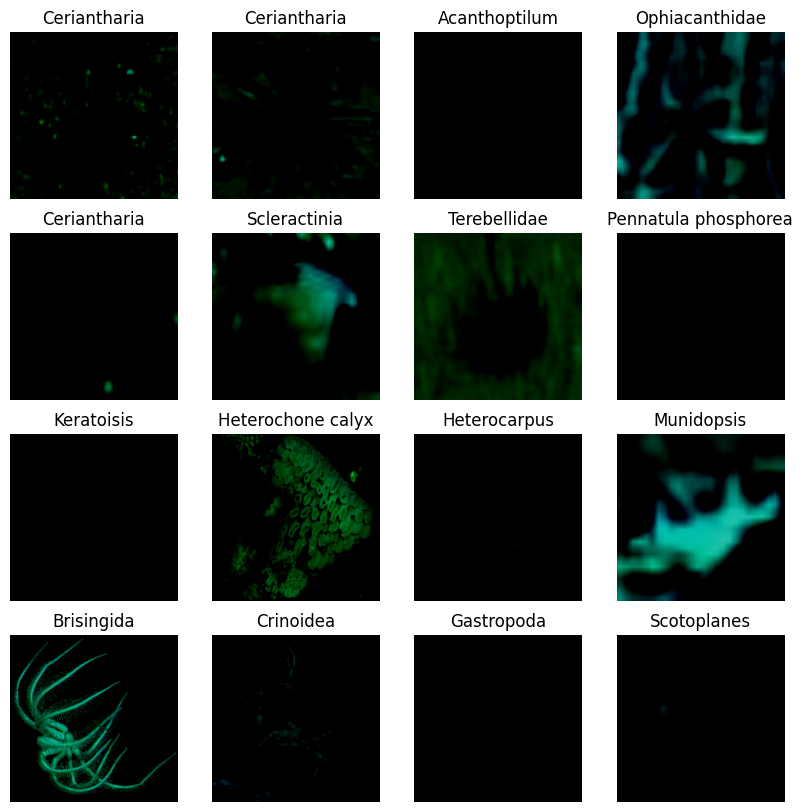

In [12]:

# Define a denormalization function
def denormalize(tensor):
    mean = torch.tensor([-0.56, -0.12, -0.12]).view(1, 3, 1, 1)
    std = torch.tensor([0.35, 0.36, 0.30]).view(1, 3, 1, 1)
    return tensor * std + mean  # Reverse normalization

# Reverse label mapping
reverse_label_mapping = {idx: name for name, idx in label_mapping.items()}

# Display function
def display_batch(dataloader):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)

    # Denormalize images
    images = denormalize(images)

    fig, axes = plt.subplots(4, 4, figsize=(10, 10))  # Adjust grid size

    for i, ax in enumerate(axes.flatten()):
        if i < len(images):
            img = np.transpose(images[i].cpu().numpy(), (1, 2, 0))  # Convert tensor to image
            img = np.clip(img, 0, 1)  # Clip values to valid range

            label_name = reverse_label_mapping[labels[i].item()]  # Get species name
            ax.imshow(img)
            ax.set_title(label_name)
            ax.axis("off")

    plt.show()

# Call the function
display_batch(dataloader)

In [17]:
import torch.nn as nn

class MarineClassifier(nn.Module):
    def __init__(self, clip_model, num_classes):
        super(MarineClassifier, self).__init__()
        self.clip_model = clip_model
        
        # Freeze all layers initially
        for param in self.clip_model.parameters():
            param.requires_grad = False
        
        # Unfreeze last two layers (adjust based on architecture)
        for name, param in self.clip_model.visual.named_parameters():
            if "layer4" in name or "layer3" in name:  # Modify based on model architecture
                param.requires_grad = True
        
        self.fc = nn.Linear(self.clip_model.visual.output_dim, num_classes)  # Classification head

    def forward(self, images):
        features = self.clip_model.encode_image(images)  # Extract visual embeddings
        out = self.fc(features)
        return out

In [18]:
num_classes = len(label_mapping)  # Number of distinct marine species
classifier = MarineClassifier(model, num_classes)

In [19]:
criterion = nn.CrossEntropyLoss()  # Standard classification loss
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, classifier.parameters()), lr=1e-5)

In [20]:
def train(model, dataloader, criterion, optimizer, epochs):
    model.train()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        total_loss = 0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU if available
            
            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

# Train for 10 epochs
train(classifier, dataloader, criterion, optimizer, epochs=3)

KeyboardInterrupt: 